<a href="https://colab.research.google.com/github/mannixp/CHIST/blob/main/PDF_Construction_using_extruded_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update --fix-missing

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

/bin/bash: line 1: apt-get: command not found


firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


**Part 1 - Computing the CDF**

**A) Background**

Given a numerical approximation of a random field or random function $Y(\mathbf{x})$ over an arbitrary domain $\mathbf{x} \in \Omega_X$ (which can be thought of as a subset of the multidimensional space $\mathbb{R}^n$), we want to calculate its corresponding cumulative density function (CDF) $F(y)$ and probability density function (PDF) $f(y)$ such that these functions are continuous and make the best possible use of the available data. The CDF of $Y(\mathbf{x})$ is given by
\begin{equation*}
    F(y) = \frac{1}{\mu(\Omega_X)}\int_{\Omega_X} \mathbb{I}_{Y(\mathbf{x}) < y>}(\mathbf{x}) d \mathbf{x},
\end{equation*}
where 
\begin{equation*}
    \mathbb{I}_{Y(\mathbf{x}) < y}(\mathbf{x})  =
    \begin{cases}
    1 \quad &: Y(\mathbf{x}) < y, \\
    0 \quad &: \text{otherwise}.
    \end{cases}
\end{equation*}
is the indicator function induced by $Y(\mathbf{x})$ and $\mu(\Omega_X)$ is the volume of the domain. Differentiating the CDF its PDF $f(y) = \partial_y F(y)$ is then easily recovered. Unfortunately, the integral of the indicator function is in practice difficult to calculate and the common approach is to jump from the analytical expression for $F(y)$ directly to its piecewise constant approximation outlined below.

To illustrate this consider calculating the CDF of $Y(\mathbf{x}_i) = (Y_1, Y_2, \cdots ,Y_n)$ here taken to be a uniformly sampled vector of $n$ discrete points. To calculate a discrete approximation of its CDF we can sort the data to obtain
\begin{equation*}
    F(y) \approx \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{Y_i \leq y}
\end{equation*}
which jumps up by $1/n$ at each data point and thus lets the data discretise the codomain $\Omega_{Y}$, or we can impose a discretisation of $m$ bins $y_0 < y_1 < \cdots < y_m$ and obtain the approximation
\begin{equation*}
    F(y_m) \approx \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{Y_i \leq y_m}
\end{equation*}
which jumps up between bins by $F(y_2) - F(y_1) \neq 1/m$, and takes a constant value within each bin. While this guarantees a monotonic CDF it is clearly discontinuous and has not made the best use of our data as shown in the example below. Here we consider the function $Y(x_1) = \sin(x_1)^2$ where $x_1 \in [0,2 \pi)$, and plot (a) its CDF $F_Y(y)$, (b) a contour level of its extended CDF $\hat{F}_Y(y)$ as function of $x_1,y$ and (c),(d) the indicator function $\mathbb{I}_{Y(x_1) < y}(x_1)$.

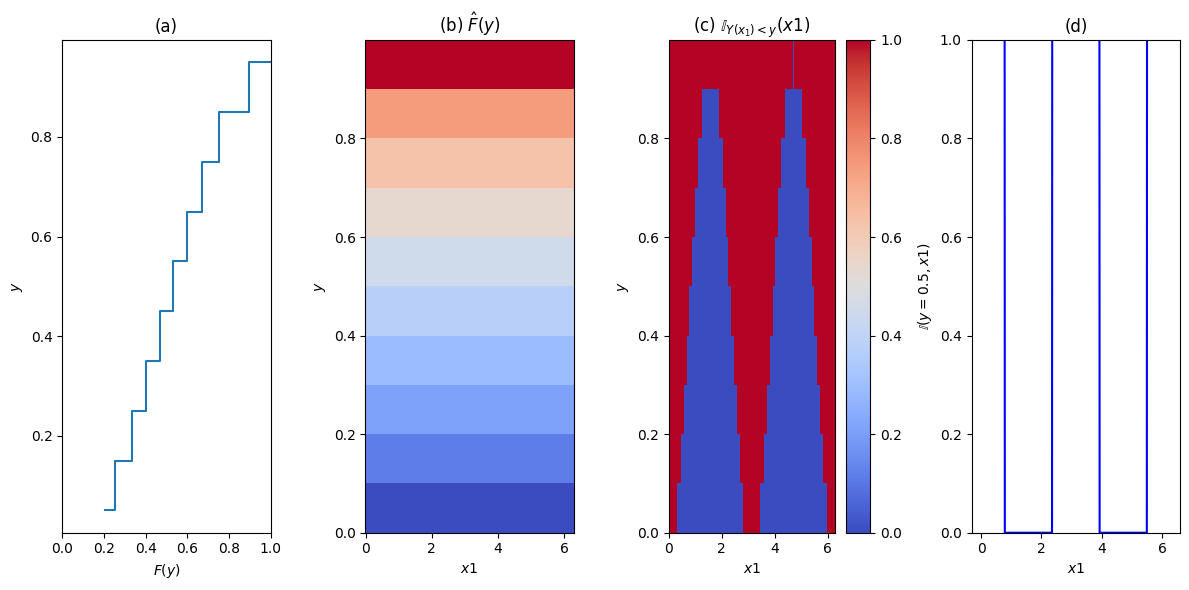

In [2]:
import numpy as np
import matplotlib.pyplot as plt

n    = 10    # Number of bins
n_x1 = 10**3 # Numerical grid for Y(x_1)

# Function
x1 = np.linspace(0,2*np.pi,n_x1)
Y  = lambda x: np.sin(x)**2;

# Indicator function
I  = lambda Y,y_m: [1 if Y_i < y_m else 0 for Y_i in Y];

# Construct CDF
dy  = abs( max(Y(x1)) - min(Y(x1)) )/n;
y   = np.arange(min(Y(x1)),max(Y(x1))+dy,dy);

IYX = np.zeros((n,n_x1))
for i,y_m in enumerate(y[1:]):
  IYX[i,:] = I(Y(x1),y_m) # If Y(x1) < y_n left bin edge

F  = np.mean(IYX,axis=1)  # Integrate out x
y_c= (y[1:] + y[:-1])/2.; # Convert to bin centres

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(141)
ax1.plot(F,y_c,drawstyle='steps-mid')
ax1.set_xlim([0,1])
ax1.set_title(r'(a)')
ax1.set_ylabel(r'$y$')
ax1.set_xlabel(r'$F(y)$')

ax2 = fig.add_subplot(142)
ax2.set_title(r'(b) $\hat{F}(y)$')
ax2.pcolormesh(x1,y_c,np.outer(np.ones(n_x1),F).T,cmap='coolwarm')
ax2.set_xlabel(r'$x1$')
ax2.set_ylabel(r'$y$')

ax3 = fig.add_subplot(143)
ax3.set_title(r'(c) $\mathbb{I}_{Y(x_1) < y}(x1)$')
im = ax3.pcolormesh(x1,y_c,IYX,cmap='coolwarm')
fig.colorbar(im, ax=ax3)
ax3.set_xlabel(r'$x1$')
ax3.set_ylabel(r'$y$')

ax4 = fig.add_subplot(144)
ax4.plot(x1,I(Y(x1),0.5),'b')
ax4.set_ylim([0,1])
ax4.set_title(r'(d)')
ax4.set_xlabel(r'$x1$')
ax4.set_ylabel(r'$\mathbb{I}(y=0.5,x1)$')

plt.tight_layout()
plt.show()

In the example above we have (1) implicitly assumed a basis of piecewise constant functions and (2) regarded the random field not as a continuous function of space but instead as a vector of grid point evaluations. How do we refine this "binning" approach? 

**B) Theory**

To address the first point we can define an appropriate function space $V_F$ for $F$, which for simplicity we choose the space of square integrable functions
\begin{equation*}
    F \in V_F \subset L^2(\Omega_Y), \quad \text{where} \quad F: \Omega_Y \to [0,1] \quad \text{s.t.} \; \int F^2 dy < \infty,
\end{equation*}
and define the set of basis functions $V_F = span\{\phi_i(y)\}$ such that
\begin{equation*}
    F(y) = \sum_i F_i \phi_i(y).
\end{equation*}
Although this formulation makes recovering $f(y)$ more complicated, there is no reason or requirement that $F(y)$ should not contain jumps. To address the second point we now consider the projection of $F(y)$ into $V_F$ as defined by
\begin{equation*}
    \int_{\Omega_X \times \Omega_Y} \hat{F} \hat{v} \; dy d \mathbf{x} = \int_{\Omega_X \times \Omega_Y} \mathbb{I}_{Y(\mathbf{x}) < y}(\mathbf{x}) \hat{v} \; dy d \mathbf{x},
\end{equation*}
where $\hat{v},\hat{F} \in \hat{V}_F$ denotes the extension of $v,F \in V_F$ into $\Omega$. Substituting in for $\hat{F}$ and considering the projection component-wise we obtain
\begin{equation}
    \sum_{i,j} \left[ \int_{\Omega_X \times \Omega_Y} \hat{\phi}_i \hat{\phi}_j \; dy d \mathbf{x} \right] f_j = \sum_i \left[ \int_{\Omega_X \times \Omega_Y} \mathbb{I}_{Y(\mathbf{x}) < y}(\mathbf{x}) \hat{\phi}_i(y,\mathbf{x}) \; dy d \mathbf{x} \right],
\end{equation}
where the left hand side denotes the bilinear form and the right hand side the linear form. Applying this equation to the example problem, we find that the precise statement of the function spaces for $\hat{F}$ and its basis functions $\hat{v}$ is
\begin{equation*}
    \hat{V}_F = V_F \times R,
\end{equation*}
the space of square integrable functions $V_F$ times $R$ the space of functions which are constant over the whole domain. These spaces correspond to the $y$ and the $x_1$ axis of frame (b) in the example shown above, whose 1D projection is shown in frame (a). In frames (c) and (d)  we highlight the discontinuous dependence of the indicator function on $y,x_1$.

<center><img src="Schematic_without_caption.png"><center>

<!-- Figure 1: The CDF $F(y)$ of the 1D function $Y(x)$ is constructed by projecting the integral of the indicator function directly into a piece-wise discontinuous finite element space of $N_y$ elements (4 in this schematic). The extended function $\hat{Y}(x)$ (a) and CDF $\hat{F}(y)$ (b) are defined on the extended domain $\Omega_Y \times \Omega$ which is discretised in $y$ but not $x$. -->

Figure 1: The CDF $F_Y$ of $Y(x)$ is constructed by projecting the integral of the indicator function onto the discontinuous piecewise linear finite element space (DG1), which in this schematic has 5 elements. (left) The extended function $\hat{Y}(x, y) = Y(x)$, (middle) the indicator function $\mathbb{I}_{Y(x)<y}$ induced by $Y(x)$ and (right) the extended CDF $\hat{F}_Y(x, y) = F_Y(y)$ are defined on the domain $\Omega_X \times \Omega_Y$ which is discretised in $y$ but not in $x$. By representing $F_Y$ using DG1, regions of width $\Delta$ where $Y(x) = y_0$ is constant are correctly described as jumps of height $\Delta$ at $y_0$ in the CDF.

To help provide intuition regarding the projection defined by equation (1), and to justify the extension of $Y(x)$ into $y$ to create $\hat{Y}(x,y)$ and the CDF $F(y)$ into $x$ to create $\hat{F}(x,y)$, a schematic is provided in figure 1. The sample space $y$ is discretised using $N_y$ finite elements while the $x$ direction is not discretised. This treatment of the $x$ direction is important as it means that $\mathbb{I}_{Y(x)<y}$ remains analytic, that $Y(x)$ is treated as a random function of space and that we have not made any approximation of the right hand side. If however, we first integrated out the $x$ dependency of the indicator function and then projected the CDF into a finite element space, we would be numerically approximating the CDF prior to evaluating this projection. The projection we have outlined therefore avoids this approximation, but it does so at the cost of increasing the dimensionality of the numerical calculation. For example the 1D function $Y(x)$ requires extension into $y$, thus making the problem 2D as shown in figure 1. By extension a function $Y(\mathbf{x})$ defined on an n dimensional space $\mathbb{R}^n$ will, when extended into $y$, result in a $N+1$ dimensional problem.

**c) Numerical implementation**

We begin by constructing a mesh for $\mathbf{x} \in \Omega_X$, which if 1D is an interval mesh and if 2D a rectangular mesh. As we have an analytical expression, or at least have a continuous representation of our data, we can replace the real space $\mathbb{R}$ by a single discrete Galerkin element of zero order (DG0). Extruding this mesh into $y \in \Omega_Y$ and discretising the interval using $N_y$ elements, we specify a piecewise linear function space for $F(y)$ that is discontinuous between elements (also known as DG1). After constructing the CDF we will justify our choice of these function spaces.

In [3]:
from firedrake import *
from firedrake.__future__ import interpolate

# Construct the mesh
Ny   = 10 # Vary the number of mesh cells
m_x  = IntervalMesh(1,0,2*np.pi); cell_type = "interval";  # x-direction
mesh = ExtrudedMesh(m_x, layers=Ny,layer_height=1./Ny,extrusion_type='uniform') # y-direction

# Set the function-space \hat{V}_F
R   = FiniteElement(family="DG" ,cell=cell_type,degree=0, variant="equispaced")
V_F = FiniteElement(family="DG",cell="interval",degree=1, variant="equispaced")

elt_RVF = TensorProductElement(R,V_F)
V_hat_F = FunctionSpace(mesh,elt_RVF)

With the function spaces defined we then define the indicator function $\mathbb{I}(y,\mathbf{x})$ which acts on the random function $Y(\mathbf{x})$

In [4]:
# Define the indicator function
x1,y = SpatialCoordinate(mesh)
Indicator = conditional(sin(x1)**2  < y, 1, 0)

We then declare the bilinear and linear forms for the left and right hand sides of our equation and solve, by defining $F$ to be a function holding the solution and then passing this along with $a$ and $L$ to a solver. An additional argument we specify when constructing the linear form is the degree of the quadrature rule used to integrate the right hand side. In our case a high order rule is necessary to contend with the discontinuous dependency of the indicator function, as shown in frames (c) and (d) of the earlier figure.

In [5]:
u = TrialFunction(V_hat_F)
v = TestFunction(V_hat_F)

a = inner(u,v) * dx
L = inner(Indicator,v) * dx(degree=250) # Vary the order of the quadrature rule

F_hat = Function(V_hat_F)
solve(a == L,F_hat)

To recover the 1D function $F(y)$, we create a new mesh and ascribe a function space upon which we can define a function to contain the data associated with the extended function's $\hat{F}(y,\mathbf{x})$ degrees of freedom.

In [6]:
# Define a mesh,function space & the CDF F which lives in this space
m_y = IntervalMesh(Ny,0,1);
V_F = FunctionSpace(mesh=m_y,family="DG",degree=1);
F   = Function(V_F)

# create new function y_Fs on function space V
y,  = SpatialCoordinate(m_y)
y_Fs= assemble(interpolate(y,V_F)) # Creates a function y in V_F

# Now we sort these in ascending order
# This is because the DOFs for the extended mesh are in ascending order
indx = np.argsort(y_Fs.dat.data)

# Pass the data from F_hat into F
F.dat.data[indx] = F_hat.dat.data[:]

Finally we can plot this out using firedrake's inbuilt routine

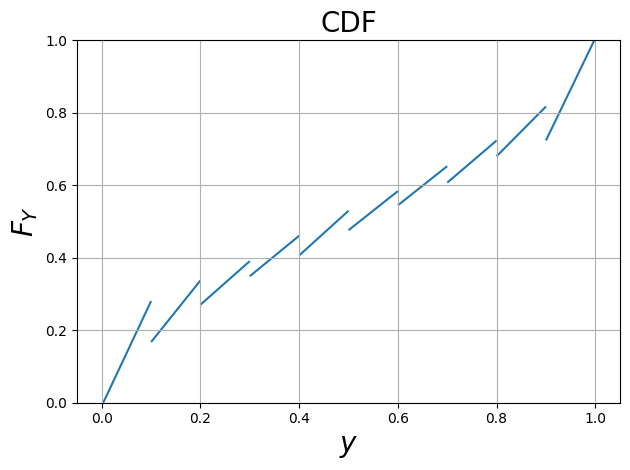

In [7]:
import matplotlib.pyplot as plt
from firedrake.pyplot import plot

Line2D = plot(F,num_sample_points=50)
plt.title(r'CDF',fontsize=20)
plt.ylabel(r'$F_Y$',fontsize=20)
plt.xlabel(r'$y$',fontsize=20)
plt.ylim([0,1])
plt.tight_layout()
plt.grid()
plt.show()

**D) Slope limiter**

In order to construct a CDF we must have a non-decreasing and right-continuous function $F(y)$. As we chose the space of piecewise linear functions rather than piecewise constant functions, we cannot guarantee these conditions are satisfied and must therefore apply a slope limiter to construct a valid CDF. By choosing an intentionally small quadrature degree, we have forced our approximation of $F(y)$, as shown in the previous figure, to deviate from what constitutes a valid CDF. Given that this reassignment of slopes is a nonlinear process, we shall use an iterative relaxation method to ensure convergence of the slope updating scheme.

 
Our algorithm assumes a finite element discretisation consisting of $N_e$ piecewise discontinuous linear finite elements, such that we have $2N_e$ degrees of freedom (dofs) and $N_e + 1$ facets (the boundary between elements). In the above example we use $10$ elements and so there is $11$ facets. We assume the dofs correspond to point evaluations at the left and right endpoints of each element. In order to update these dofs we must calculate a set of jump conditions which we can use to limit the slope.

To calculate these jump conditions, we label the value approaching the left of a arbitrary facet $a_-$ and the value approaching from the right $a_+$. Using this notation we can then calculate the jump (at iteration $n$) at each facet according to

\begin{equation}
j^n = \begin{cases} a^n_+-a^n_-, \qquad\qquad \qquad\qquad \text{if} \; a^n_+ < a^n_-, \\ min(a^n_+,a^0_-) - a^n_-, \qquad\qquad \text{otherwise} \end{cases}
\end{equation}

where the first condition is equal to the amount by which the CDF is currently decreasing at this facet, while the second condition is the amount by which we can adjust the slope back towards its original CDF before the slope limiter was applied, all whilst maintaining a non-decreasing CDF. This condition is implemented below.

In [8]:
def jump_condition(a_n_minus, a_n_plus, a_0_minus):
    if a_n_plus < a_n_minus:
        return a_n_plus-a_n_minus
    else:
        return min(a_n_plus, a_0_minus) - a_n_minus

In order to determine the jump at the left- and right-most boundaries we must also specify boundary conditions for the CDF. These are imposed by setting either $a_-$ or $j^n$ equal to zero at the left-most boundary and either $a_-$ equal to one, or $j^n$ equal to zero, at the right-most boundary. If $\Omega_Y$ is chosen such that the range of $Y(x)$ is a subset of the domain (i.e. $\text{Range}(Y(x)) \subseteq \Omega_Y$), then we must impose Dirichlet boundary conditions to account for any mass lost due to discretisation error. This translates to specifying
\begin{equation}
    j^n = a^n_+ - 0,
\end{equation}
at the lower boundary and 
\begin{equation}
    j^n = 1 - a^n_-
\end{equation}
at the upper boundary. As the discretisation error reduces with increasing resolution, $\mathsf{F}_Y(y)$ will tend to $0$ and $1$ at the lower and upper boundaries respectively and so this jump will tend to zero. Alternatively, if the domain is a subset of the range of $Y(x)$ (i.e. $\text{Range}(Y(x)) \supset \Omega_Y$), the CDF should not tend to zero and one at the lower and upper boundary respectively as we do not want to account for the mass beyond the end points of the domain. Although the boundary conditions for this case correspond to inhomogeneous Neumann boundary conditions, it is easily treated by specifying $j^n=0$, at the left- and right-most boundaries. This follows from the fact that continuity of the derivative at the boundary of $\partial \Omega_Y$ implies that the jump is zero.


As each element $e$ has a set of two jump values associated to it, one at its left facet and one at its right facet, we must choose the minimum of these two values (i.e. the most negative of the two), such that all negative slopes of the piecewise linear elements of the CDF are removed, that is $j^n = min\{j^n_{l},j^n_r\}$. This of course comes with the price of potentially increasing the positive overshoot at some facets. The calculation of $j^n$ is implemented below on a cell by cell basis, in the form of a function which takes in the original CDF $F_0$ (before the slope limiter was applied) and the current CDF $F$ (resulting from the last application of the slope limiter).

In [9]:
def jumps(F, F_0, Omega_Y, Range_Y):

    # The 2*N_e dofs contained in F are stored from left to right
    # we reshape the array to be of dimensions (N_e,2), so the first
    # axis indexes the element and the second its left and right dof.

    # Create an array containing a_0_minus,a_0_plus
    celldata_0 = F_0.dat.data[:].reshape((-1, 2))

    # Create an array containing a_n_minus,a_n_plus
    celldata_n = F.dat.data[:].reshape((-1, 2))
    ne = celldata_n.shape[0]
    
    # Create an empty array to store the jumps
    jumps = np.zeros(ne)

    # Go through the cells from left to right
    for e in range(ne):

        # (1) cell data
        # e - 1
        if e == 0:
            cell_n_em1 = np.zeros(2)
            cell_0_em1 = np.zeros(2)
        else:
            cell_n_em1 = celldata_n[e-1, :]
            cell_0_em1 = celldata_0[e-1, :]
        
        # e
        cell_n_e = celldata_n[e, :]
        cell_0_e = celldata_0[e, :]

        # e + 1
        if e == ne-1:
            cell_n_ep1 = np.ones(2)
        else:
            cell_n_ep1 = celldata_n[e+1, :]
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        # (2) Apply bcs and calculate the jump conditions & then take their minimum
        if e == 0:
            if min(Omega_Y) < min(Range_Y): 
                # Dirichlet BC at the left most boundary F(-∞) = 0
                left = jump_condition(a_n_minus=cell_n_em1[1],a_n_plus=cell_n_e[0],a_0_minus=cell_0_em1[1])
            elif min(Omega_Y) >= min(Range_Y):
                # Neumann BC no jump in F [[F]] = 0
                left = 0
        else:
            left = jump_condition(cell_n_em1[1], cell_n_e[0], cell_0_em1[1])
        
        if e == ne-1:
            if max(Omega_Y) > max(Range_Y): 
                # Dirichlet BC at the right most boundary F(+∞) = 1
                right = jump_condition(cell_n_e[1], cell_n_ep1[0], cell_0_e[1])
            elif max(Omega_Y) <= max(Range_Y):
                # Neumann BC no jump in F [[F]] = 0
                right = 0
        else:
            right = jump_condition(cell_n_e[1], cell_n_ep1[0], cell_0_e[1])
        
        jumps[e] = min(left, right)
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    return jumps

Having calculated the jumps we then add $j^n$ to each left hand dof and subtract $j^n$ from each right hand dof. This is done in an iterative fashion by choosing a small update size $\alpha \approxeq 0.1$, such that the final update at each iteration is given by

\begin{align*} 
\text{dof}_{left} &= \text{dof}_{left} + \alpha j^n, \\ 
\text{dof}_{right} &= \text{dof}_{right} - \alpha j^n,
\end{align*}

This procedure continues until the Cartesian norm $||j^n - j^{n+1}||_2/||j^{n-1}||_2 < \epsilon$ falls below a user defined threshold, or if the slopes of elements cannot prevented from being negative after a certain number of iterations is reached.

Iteration i=10  error =  0.24999999961898003 slope = 0.05753723685184231 



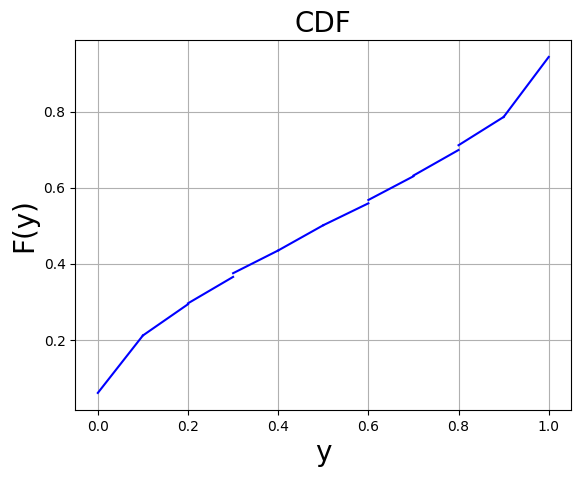

Iteration i=20  error =  0.2500000090208361 slope = 0.05753723030995994 



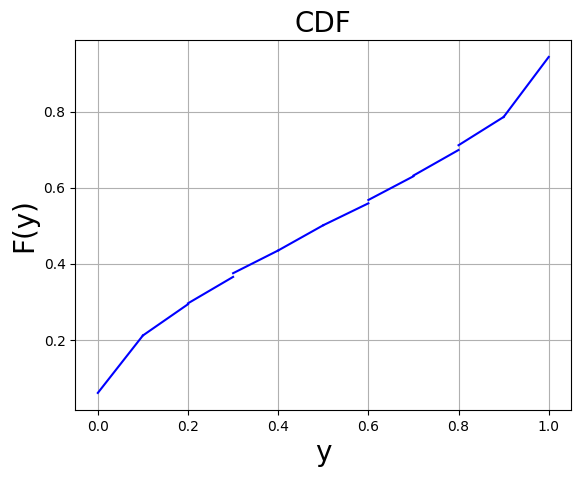

Iteration i=30  error =  0.2500000154985034 slope = 0.057537229607530715 



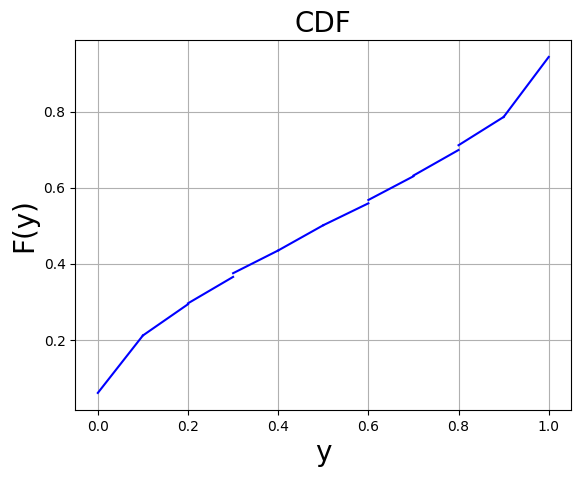

Iteration i=40  error =  0.2500002627698083 slope = 0.057537229532107714 



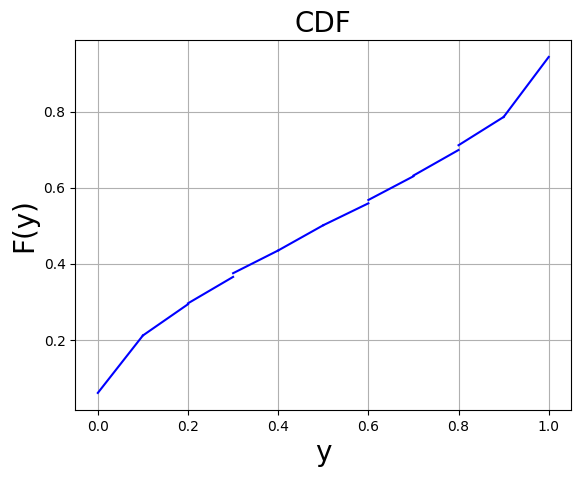

Iteration i=50  error =  0.24999791085416112 slope = 0.0575372295240093 



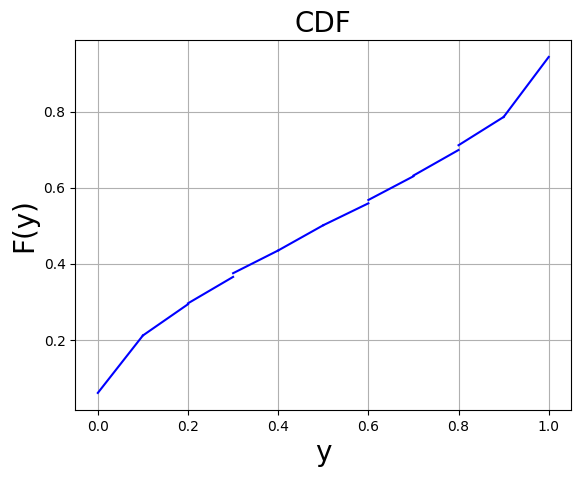

In [15]:
import copy
    
# Create a copy of the original not slope limited CDF
F_0 = copy.deepcopy(F)

# Grab the number of elements
ne  = F_0.dat.data[:].reshape((-1, 2)).shape[0]

# Determine Omega_Y
mesh_y = F.function_space().mesh()
y      = mesh_y.coordinates.dat.data[:]
Omega_Y = np.array([min(y), max(y)])

# Determine the range of Y(x1)
x1   = np.linspace(0,2*np.pi,n_x1)
Y    = lambda x: np.sin(x)**2;
Range_Y = np.array([min(Y(x1)), max(Y(x1))]) 

# A) Relaxation loop
error = 1
iter = 0
slope = -1
jo = np.zeros(ne)
alpha = 0.1
while (error > 0.01 or slope < 0) and (iter < 50):

    # (1) Update dats
    jn = jumps(F, F_0, Omega_Y, Range_Y)
    F.dat.data[:].reshape((-1, 2))[:, 0] -= alpha*jn
    F.dat.data[:].reshape((-1, 2))[:, 1] += alpha*jn

    # (2) Error
    iter += 1
    if np.linalg.norm(jn) == 0:
        error = 0.
    else:
        error = np.linalg.norm(jn - jo, 2)/np.linalg.norm(jn, 2)
    jo = jn

    # (3) Calculate the slope
    slopes = F.dat.data[:].reshape((-1, 2))[:, 1] - F.dat.data[:].reshape((-1, 2))[:, 0]
    slope = np.min(slopes)
    if abs(slope) < 1e-12:
        slope = 0.

    # (4) Plot out the CDF as the limiter operates
    if iter%10==0:
        print('Iteration i=%d' % iter, ' error = ', error, 'slope =', slope, '\n')
        l = np.arange(0,1,0.1)
        r = np.arange(0.1,1.1,0.1)
        X = np.vstack([l,r]).T
        for i in range(ne):
            plt.plot(X[i,:],F.dat.data[:].reshape((-1, 2))[i,:],'b')
        plt.ylabel('F(y)',fontsize=20)
        plt.xlabel('y',fontsize=20)
        plt.title('CDF',fontsize=20)
        plt.grid()
        plt.show()

# B) Remove remaining illegal discontinuities not captured during the relaxation
jn = jumps(F, F_0, Omega_Y, Range_Y)
F.dat.data[:].reshape((-1, 2))[:, 0] -= jn
F.dat.data[:].reshape((-1, 2))[:, 1] += jn

As demonstrated above the slope limiter correctly removes negative slopes present.

Throughout this notebook we restricted our implementation to the discontinuous piecewise linear finite element space DG1. DG1 is chosen because slope limiters are easier to apply in this setting in order to guarantee monotonicity between elements. While DG2 or higher order finite element spaces could be chosen, the slope limiter becomes more complicated for these cases. This is because one must guarantee monotonic behavior not only between elements but also within the elements. An additional motivation for restricting our implementation to DG1, is that the underlying function being approximated (as evidenced by the first figure in this notebook) is not polynomial. Given that numerical quadrature employed in the Galerkin project will therefore not be exact, it is unlikely that much benefit would be gained from availing of a higher order scheme, particularly given that most methods reduce to first order accuracy when slope limited.